<a href="https://colab.research.google.com/github/raquibaS/Transformers-for-Natural-Language-Processing/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps to finetune a model:
1. Load the dataset
2. Preprocess:
    a) define tokenizer
    b) map tokenizer with the dataset
    c) Padding the data with Datacollator
3. Fine Tune:
    a) Define the model (Load pretrained model from Huggingface)
    b) Define training hyper parameters
    c) Pass the training arguments to Trainer along with model, dataset, tokenizer and data collator
    d) Call train() to fine tune the model


Important Sources that I followed:
1. Exploratory Data Analysis: https://medium.com/m2mtechconnect/detecting-headline-sarcasm-with-machine-learning-4c3523104cdf#d58f

## Install transformers and other things

In [138]:
#!pip install -U transformers

In [139]:
!pip install transformers

In [140]:
!pip install pyyaml

In [141]:
!pip install numpy

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Load the dataset

In [143]:
!pip install datasets

In [144]:
#!pip install folium==0.2.1

## Activate GPU

In [145]:
# Checking if GPU and NVIDIA are available
!nvidia-smi

Wed Apr 13 04:51:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |   1683MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Specifying CUDA as the device for torch

In [146]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [147]:
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Initialize dataset

In [148]:
df = pd.read_json(r'Sarcasm_Headlines_Dataset_v2.json', lines=True)
df = df.drop(['article_link'], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [149]:
df = df.rename(columns={'is_sarcastic':'label', 'headline':'text'})

In [150]:
df

,label,text
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


In [151]:
first_column = df.pop('text')
df.insert(0,'text',first_column)

In [152]:
df.head()

,text,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [153]:
#Now we can take a look at the full text of the first few headlines:\

for i in range(0, 5):
    print(df.iloc[i]["text"], '\n')

thirtysomething scientists unveil doomsday clock of hair loss 

dem rep. totally nails why congress is falling short on gender, racial equality 

eat your veggies: 9 deliciously different recipes 

inclement weather prevents liar from getting to work 

mother comes pretty close to using word 'streaming' correctly 



## Exploratory Data Analysis

In [154]:
df.label.value_counts()

0    14985
1    13634
Name: label, dtype: int64

In [155]:
df.text.value_counts()

'no way to prevent this,' says only nation where this regularly happens    12
sunday roundup                                                             10
the 20 funniest tweets from women this week                                10
the funniest tweets from parents this week                                  6
report: make it stop                                                        4
                                                                           ..
palm tree in hurricane irma's path ready to bend real good for cameras      1
man lived alongside dead father's body for four months                      1
obama family adopts 44-year-old portuguese water man                        1
we need to treat gun violence like a public health problem                  1
dad clarifies this not a food stop                                          1
Name: text, Length: 28503, dtype: int64

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28619 non-null  object
 1   label   28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [157]:
df.label.dtypes

dtype('int64')

In [158]:
df.text.dtypes

dtype('O')

We have 26709 samples and no missing values in this dataset.
For further analysis, group our dataset by class:

In [159]:
groups = df.groupby('label')

In [160]:
groups.get_group(0)

,text,label
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
5,my white inheritance,0
6,5 ways to file your taxes with less stress,0
9,lots of parents know this scenario,0
...,...,...
28607,what our grieving family needs from loved ones...,0
28608,stephen colbert attempts to list everything tr...,0
28609,bakery owner vows to stop making wedding cakes...,0
28613,how san antonio's dominant defense is fueling ...,0


In [161]:
groups.get_group(1)

,text,label
0,thirtysomething scientists unveil doomsday clo...,1
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
7,richard branson's global-warming donation near...,1
8,shadow government getting too large to meet in...,1
...,...,...
28612,polish rapper under fire for use of the word '...,1
28614,jews to celebrate rosh hashasha or something,1
28615,internal affairs investigator disappointed con...,1
28617,mars probe destroyed by orbiting spielberg-gat...,1


We can check the number of samples per class:

In [162]:
num_sarcastic = len(groups.get_group(1))
num_nonsarcastic = len(groups.get_group(0))

In [163]:
print("Total number of sarcastic samples:", num_sarcastic)
print("Total number of nonsarcastic samples:", num_nonsarcastic)

Total number of sarcastic samples: 13634
Total number of nonsarcastic samples: 14985


Now we can check the number of samples per class:

In [164]:
def get_median_num_words(df):
    """Returns the median number of words in headline per row given dataframe

    # Arguments
        df: dataframe, contains headlines and their labels
    
    # Returns
        int, median number of words per headline
    """
    num_words = [len(s.split()) for s in df.text]
    return np.median(num_words)

# median number of words per sample
num_words_sarcastic = get_median_num_words(groups.get_group(1))
num_words_nonsarcastic = get_median_num_words(groups.get_group(0))
print("Average number of words in sarcastic sentences:",num_words_sarcastic)
print("Average number of words in nonsarcastic sentences:", num_words_nonsarcastic)

Average number of words in sarcastic sentences: 10.0
Average number of words in nonsarcastic sentences: 10.0


We have 11724 sarcastic samples and 14985 nonsarcastic samples. There is a slight class imbalance, but it’s small enough that I’ll ignore it for this project. As for the median number of words per headline, it is 10 for both classes.
Here are the plots of the sample length distribution for both sarcastic and nonsarcastic headlines:

In [165]:
def plot_sample_len_distribution(df):
    """Plots the headline length distribution
    # Arguments
        df: dataframe, contains headlines and their labels
    """
    plt.hist([len(s) for s in df.text],bins=50)
    plt.xlabel('sample length')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

Plots the headline length distribution for sarcastic headline

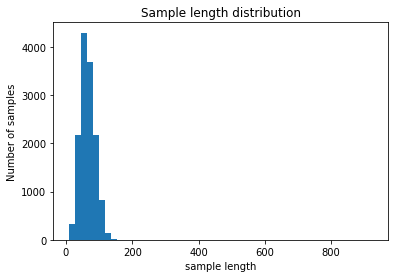

In [166]:
# Plots the headline length distribution for sarcastic headline
plot_sample_len_distribution(groups.get_group(1))

Plots the headline length distribution for nonsarcastic headline

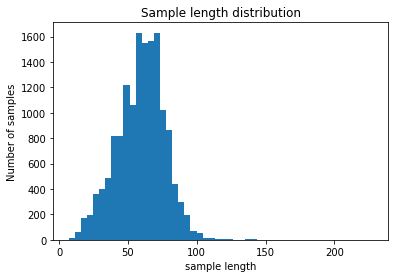

In [167]:
# Plots the headline length distribution for nonsarcastic headline
plot_sample_len_distribution(groups.get_group(0))

### Pretraining

Split the train and test data

In [168]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [169]:
train

,text,label
4724,"how trump really feels about queer people, exp...",0
26559,egyptian death sentence for soccer fans puts p...,0
24613,stripper failing school she's working self thr...,1
9048,texas attorney general ken paxton indicted,0
69,congresswoman fights for gun control because s...,0
...,...,...
21575,turnout lower than expected for gala central a...,1
5390,retreating clinton campaign torches iowa town ...,1
860,national weather service to give hurricanes fu...,1
15795,christ returns for some of his old things,1


In [170]:
train.dtypes

text     object
label     int64
dtype: object

In [171]:
#train["label"] = train["label"].apply(lambda x: map(int, x))

In [172]:
train.info

<bound method DataFrame.info of                                                     text  label
4724   how trump really feels about queer people, exp...      0
26559  egyptian death sentence for soccer fans puts p...      0
24613  stripper failing school she's working self thr...      1
9048          texas attorney general ken paxton indicted      0
69     congresswoman fights for gun control because s...      0
...                                                  ...    ...
21575  turnout lower than expected for gala central a...      1
5390   retreating clinton campaign torches iowa town ...      1
860    national weather service to give hurricanes fu...      1
15795          christ returns for some of his old things      1
23654  loophole in curse lets archaeologist off the hook      1

[22895 rows x 2 columns]>

In [173]:
#Convert the data from pandas dataset
from datasets import Dataset
train_data = Dataset.from_pandas(train, preserve_index=False) # To remove __index_level_0__ column, this column was causing Key_Error
test_data = Dataset.from_pandas(test, preserve_index=False) # To remove __index_level_0__ column, this column was causing Key_Error

In [174]:
# show the value of train data
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 22895
})

In [175]:
# show the value of test data
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 5724
})

In [176]:
train_data[0]

{'label': 0,
 'text': 'how trump really feels about queer people, explained in one sentence'}

In [177]:
test_data[0]

{'label': 0,
 'text': 'states slow to shut down weak teacher education programs'}

In [178]:
#train_data = train_data.shuffle(seed=42).select([i for i in list(range(3000))])

In [179]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 22895
})

In [180]:
#test_data = test_data.shuffle(seed=42).select([i for i in list(range(3000))])

In [181]:
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 5724
})

Load DistilBERT tokenizer to process the text field:

In [182]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", padding=True, truncation=True, max_length=128)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_length": 128,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda

Create a preprocessing function to tokenize text and truncate sequences to be no longer than DistilBERT’s maximum input length:

In [183]:

#def preprocess_function(examples):
    #tokenized_batch = PreTrainedTokenizerFast(examples['text'], padding=True, truncation=True, max_length=128)
    #tokenized_batch["label"] = [str_to_int[label] for label in examples["label"]]
    #return tokenized_batch
def preprocess_function(examples):
    return tokenizer(examples["text"])
    #return tokenizer(examples["text"], padding=True, truncation=True, max_length=128)

In [184]:
tokenized_train = train_data.map(preprocess_function, batched = True)

  0%|          | 0/23 [00:00<?, ?ba/s]

In [185]:
tokenized_test = test_data.map(preprocess_function, batched = True)

  0%|          | 0/6 [00:00<?, ?ba/s]

Use DataCollatorWithPadding to create a batch of examples. It will also dynamically pad text to the length of the longest element in its batch, so they are a uniform length. While it is possible to pad the text in the tokenizer function by setting padding=True, dynamic padding is more efficient.

## Fine-tune with Trainer

In [186]:
# Load DistilBERT with AutoModelForSequenceClassification along with the number of expected labels:
from transformers import AutoConfig, AutoModel, BertForSequenceClassification
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel

model_config = AutoConfig.from_pretrained('distilbert-base-uncased', output_hidden_states=True)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=model_config)

#model = AutoModel.from_pretrained("distilbert-base-uncased", config=model_config)
#model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
#model = AutoConfig.from_pretrained("distilbert-base-uncased")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggin

In [187]:
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForSeq2Seq, DataCollatorForTokenClassification
data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
#data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding= True, return_tensors="pt")
#data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding= True, return_tensors="tf")
#data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer, padding= True, return_tensors="pt")
#data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

At this point, only three steps remain:

1. Define your training hyperparameters in TrainingArguments.
2. Pass the training arguments to Trainer along with the model, dataset, tokenizer, and data collator.
3. Call train() to fine-tune your model.

In [188]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 22895
})

In [189]:
tokenized_test

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 5724
})

In [190]:
tokenized_train[0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
  2129,
  8398,
  2428,
  5683,
  2055,
  19483,
  2111,
  1010,
  4541,
  1999,
  2028,
  6251,
  102],
 'label': 0,
 'text': 'how trump really feels about queer people, explained in one sentence'}

In [191]:
tokenized_test[0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101, 2163, 4030, 2000, 3844, 2091, 5410, 3836, 2495, 3454, 102],
 'label': 0,
 'text': 'states slow to shut down weak teacher education programs'}

### Metrics

In [192]:
import numpy as np
from datasets import load_metric

In [193]:
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [194]:
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [195]:
#Converting dictonary to tensor????

def str_to_list(data):
    # a temporary list to store the string labels
    temp_list=data["text"].list()

    # dictionary that maps integer to its string value
    label_dict = {}

    #list to store integer labels
    int_labels = []

    for i in range(len(temp_list)):
        label_dict[i] = temp_list[i]
        int_labels.append(i)

In [196]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 22895
})

In [197]:
training_args= TrainingArguments(
    output_dir = "./results",
    learning_rate = 2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs = 5,
    weight_decay = 0.01,
    evaluation_strategy="epoch",
    remove_unused_columns = False,
    optim="adamw_torch"
)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 22895
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7155


ValueError: ignored

In [ ]:
for batch in trainer.get_train_dataloader():
    break
batch = {k: v.cuda() for k, v in batch.items()}
outputs = trainer.model(**batch)

In [ ]:
for batch in trainer.get_train_dataloader():
    print({k: v.shape for k, v in batch.items()})

In [ ]:
outputs = trainer.model(**batch)
print(outputs)

##Pipeline

In [ ]:
from transformers import pipeline

In [ ]:
sentiment_analysis = pipeline("sentiment-analysis")